In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
class Identity :
  def __init__(self) :
    pass
  def __call__(self, x) :
    return x
  def derivative(self, x,y) :
    return np.ones_like(x)

class ReLU(Identity) :
  def __call__(self, x) :
    return np.maximum(x,0)
  def derivative(self, x,y) :
    return np.where(x < 0, 0, 1)

class TanH(Identity) :
  def __call__(self, x) :
    return np.tanh(x)
  def derivative(self, x,y) :
    return (1 - y*y)

class Sigmoid(Identity) :
  def __call__(self, x) :
    return 1 / (1 + np.exp(-x))
  def derivative(self, x,y) :
    return y * (1 - y)
  
class SoftMax(Identity) :
  def __call__(self, x) :
    return np.exp(x) / np.sum(np.exp(x))
  def derivative(self, x,y) :
    return np.diag(y) - np.outer(y, y)

class KL_Divergence(Identity) :
  def __call__(self, x, t) :
    return np.sum( np.where( t == 0, 0, - t * np.log(x / t)))
  def derivative(self, x,t,y) :
    return - t / x

class Binary_KL_Divergence(Identity) :
  def __call__(self, x, t) :
    if t == 0 :
      return - np.log(1-x)
    elif t == 1 :
      return - np.log(x)
    # else
    return t * np.log(t / x) + (1-t) * np.log( (1-t) / (1-x) )
  def derivative(self, x,t,y) :
    # if   x == 0 and t == 0 :
    #   return 0
    # elif x == 0 and t == 1 :
    #   return -1e4
    # elif x == 1 and t == 0 :
    #   return 1e4
    # elif x == 1 and t == 1 :
    #   return 0
    x = np.clip(x, 1e-4, 1-1e-4)
    return -t / x + (1-t) / (1-x)

class SquareError(Identity) :
  def __call__(self, x, t) :
    return np.sum( ( x - t )**2 )
  def derivative(self, x,t,y) :
    return 2 * ( x - t )


In [12]:
class Layer :
  def __init__(self, size, activation) :
    self.size = size
    self.input_size = None
    self.activation = activation
    self.output = np.zeros(size)
    self.bias = np.random.rand(self.size) * 2 - 1
    self.delta_bias = np.zeros(size)

  def set_random_state(self, random_state) :
    self.random_state = random_state
  
  def randomize(self) :
    if self.random_state is None :
      self.bias = np.random.rand(self.size) * 2 - 1
      if self.input_size is not None :
        self.weights = np.random.rand(self.size, self.input_size) * 2 - 1
    else :
      self.bias = np.random.rand(self.size) * 2 - 1
      if self.input_size is not None :
        self.weights = self.random_state.rand(self.size, self.input_size) * 2 - 1
  
  def set_input_size(self, input_size) :
    self.input_size = input_size
    if self.random_state is None :
      self.weights = np.random.rand(self.size, self.input_size) * 2 - 1
    else :
      self.weights = self.random_state.rand(self.size, self.input_size) * 2 - 1
    self.delta_weight = np.zeros(shape = (self.size, self.input_size)) 
    self.backprop_derivative = np.zeros(input_size)
  
  def calc_output(self, input_vector) :
    self.input_vector = input_vector
    self.net = self.weights @ input_vector - self.bias
    self.output = self.activation(self.net)
    return self.output
  
  def accumulate_delta_and_backprop(self, d_err_by_d_output) :
    # Calculate derivatives
    ## If the outputs are independent of each other, the derivative is vector
    ## and it is multiplied element-wise
    ## Otherwise, it will be a matrix
    # d_output_by_d_net = self.activation.derivative(self.net, self.output)
    # if len(d_output_by_d_net.shape) == 1 :
    #   d_err_by_d_net = d_err_by_d_output * d_output_by_d_net
    # else :
    #   d_err_by_d_net = d_err_by_d_output @ d_output_by_d_net
    ## Einsum takes care of both cases.
    d_err_by_d_net = np.einsum('i,i... -> i...', d_err_by_d_output, self.activation.derivative(self.net, self.output))
    d_err_by_d_weight = np.outer(d_err_by_d_net, self.input_vector)
    d_err_by_d_bias = -d_err_by_d_net
    d_err_by_d_input = d_err_by_d_net @ self.weights
    ##
    # d_err_by_d_output, d_err_by_d_net, d_err_by_d_bias, d_err_by_d_input should all be vectors
    ##
    # Accumulate derivative
    self.delta_weight += d_err_by_d_weight
    self.delta_bias   += d_err_by_d_bias
    self.backprop_derivative = d_err_by_d_input
    # Return derivative vector for backprop
    return self.backprop_derivative
  
  def regularize(self, reg_constant) :
    self.delta_weight += 2 * reg_constant * self.weights
    self.delta_bias   += 2 * reg_constant * self.bias
  
  def apply_update(self, learning_rate) :
    # Update weights
    self.weights += - learning_rate * self.delta_weight 
    self.delta_weight = np.zeros_like(self.delta_weight)
    # Update bias
    self.bias += - learning_rate * self.delta_bias
    self.delta_bias = np.zeros_like(self.delta_bias)

class InputLayer(Layer) :
  def __init__(self, size) :
    self.size = size
    self.output = np.zeros(size)
  
  def give_input_size(self, input_size) :
    pass
  
  def calc_output(self, input_vector) :
    self.output = input_vector
    return input_vector
  
  def accumulate_delta_and_backprop(self, d_err_by_d_output) :
    return np.zeros(self.size)
  
  def apply_update(self, learning_rate) :
    pass

class LossLayer(Layer) :
  def __init__(self, loss_function) :
    ## size is 1
    self.loss_function = loss_function
    self.output = 0
  
  def set_input_size(self, input_size) :
    self.input_size = input_size
  
  def calc_output(self, input_vector, target_vector) :
    self.input_vector = input_vector
    self.target_vector = target_vector
    self.output = self.loss_function(self.input_vector, self.target_vector)
    return self.output
  
  def accumulate_delta_and_backprop(self, d_err_by_d_output = None) :
    return self.loss_function.derivative(self.input_vector, self.target_vector, self.output)
  
  def apply_update(self, learning_rate) :
    pass

In [13]:
class Network :
  def __init__(self, input_size, loss_layer, hidden_layers = None, random_state = None) :
    # assert(type(input_size) == InputLayer)
    # assert(type(loss_layer) == LossLayer)
    self.input_layer = InputLayer(input_size)
    self.loss_layer = loss_layer
    # Last layer in hidden layers is the output layer
    self.hidden_layers = hidden_layers
    # Initialize weights
    current_layer = self.input_layer
    for layer in self.hidden_layers :
      layer.set_random_state(random_state)
      layer.randomize()
      layer.set_input_size(current_layer.size)
      current_layer = layer
    loss_layer.set_input_size(current_layer)
  
  def calc_output(self, input_vector) :
    current_activations = self.input_layer.calc_output(input_vector)
    for layer in self.hidden_layers :
      current_activations = layer.calc_output(current_activations)
    return self.hidden_layers[-1].output
  
  def calc_loss(self, target) :
    return self.loss_layer.calc_output(self.hidden_layers[-1].output, target)
  
  def accumulate_delta(self, weight = 1) :
    current_derivative = self.loss_layer.accumulate_delta_and_backprop()
    current_derivative *= weight
    for layer in self.hidden_layers[::-1] :
      current_derivative = layer.accumulate_delta_and_backprop(current_derivative)
    pass
  
  def regularize(self, reg_constant) :
    for layer in self.hidden_layers :
      layer.regularize(reg_constant)

  def apply_update(self, learning_rate) :
    for layer in self.hidden_layers :
      layer.apply_update(learning_rate)

In [14]:
## True palindrome boolean function
def palindrome_determiner(word) :
  return all(word == word[::-1])

def word_generator(length_of_word) :
  return np.random.randint(low=0, high=2, size=length_of_word)

def palindrome_generator(length_of_word) :
  word = np.random.randint(low=0, high=2, size=length_of_word // 2)
  if length_of_word % 2 == 0 :
    return np.hstack( [ word, np.flip(word) ] )
  else :
    return np.hstack( [word, [np.random.randint(low=0, high=2)], np.flip(word) ] )

def evaluate_confusion(model, word_length, n_cases = None) :
  confusion_matrix = [[0, 0], [0, 0]]
  if n_cases is None :
    for i in range(2**word_length) :
      word = np.array(list(map(int, list( format(i, '#0%sb' % (word_length + 2))[2:] ))))
      is_palindrome = int(palindrome_determiner(word))
      prediction = int(np.round(model.calc_output(word)))
      confusion_matrix[is_palindrome][prediction] += 1
  else :
    for i in range(n_cases) :
      word = []
      if np.random.rand() > 0.5 :
        word = word_generator(word_length)
      else :
        word = palindrome_generator(word_length)
      is_palindrome = int(palindrome_determiner(word))
      prediction = int(np.round(model.calc_output(word)))
      confusion_matrix[is_palindrome][prediction] += 1
      
  return confusion_matrix

def pretty_print_confusion(matrix) :
  print("                    | Is negative | Is positive")
  print("--------------------+-------------+--------------")
  print("Negative prediction | %11d | %11d" % (matrix[0][0], matrix[1][0]))
  print("--------------------+-------------+--------------")
  print("Positive prediction | %11d | %11d" % (matrix[0][1], matrix[1][1]))
  print("#"*40)
  precision = matrix[1][1] / (matrix[1][1] +  matrix[0][1])
  recall = matrix[1][1] / (matrix[1][1] +  matrix[1][0])
  f1 = 2 * precision * recall / ( precision + recall )
  print("Precision = %.5f, Recall = %.5f, F1 = %.5f" % (precision, recall, f1))

In [15]:
w = palindrome_generator(10)
print(w, palindrome_determiner(w))

[1 1 0 0 1 1 0 0 1 1] True


In [16]:
loss_f = Binary_KL_Divergence()
activation_f = Sigmoid()

word_length = 10

n_epochs = 15000
epoch_length = 1024
learning_rate = 5e-3
reg_constant = 0
random_source = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(126702)))

palindrome_network = Network(word_length, LossLayer(loss_f), 
                             [Layer(10, activation_f), 
                              #Layer(10, activation_f), 
                              #Layer(5, activation_f),
                              #Layer(5, activation_f),
                              Layer(1, activation_f)],
                            random_state = random_source)

loss = []

In [17]:
# word = np.array([1,0,1,0,1,1,0,1,0,1])
# n_epochs = 1

for epoch_i in tqdm(range(n_epochs)) :
  total_loss = 0
  total_importance = 0
  for test_case_i in range(epoch_length) :
    ## Randomly generate words
    # word = []
    # if np.random.rand() > 0.2 :
    #   word = word_generator(word_length)
    # else :
    #   word = palindrome_generator(word_length)
    ## Go through all words sequen tially
    word = np.array(list(map(int, list( format(test_case_i, '#0%sb' % (word_length + 2))[2:] ))))
    is_palindrome = int(palindrome_determiner(word))
    case_importance = 1 if is_palindrome else 2**(word_length //2) / (2**(word_length) - 2**(word_length //2))
    # Train
    palindrome_network.calc_output(word)
    total_loss += palindrome_network.calc_loss( is_palindrome )
    total_importance += case_importance
    palindrome_network.accumulate_delta(weight = case_importance)
  # Now update
  palindrome_network.apply_update(learning_rate)
  palindrome_network.regularize(reg_constant)
  loss.append(total_loss / epoch_length)

print(loss)

  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [38:31<00:00,  6.49it/s] 


[array([1.17728696]), array([1.03964527]), array([0.94261684]), array([0.87459712]), array([0.82684617]), array([0.79316942]), array([0.76928563]), array([0.75225355]), array([0.74004571]), array([0.73125472]), array([0.72489599]), array([0.72027576]), array([0.71690222]), array([0.714425]), array([0.71259353]), array([0.71122809]), array([0.71019948]), array([0.70941466]), array([0.70880652]), array([0.70832663]), array([0.70794]), array([0.70762134]), array([0.70735233]), array([0.70711974]), array([0.70691396]), array([0.70672806]), array([0.70655699]), array([0.70639709]), array([0.70624571]), array([0.70610091]), array([0.7059613]), array([0.70582584]), array([0.70569378]), array([0.70556458]), array([0.70543782]), array([0.70531321]), array([0.70519052]), array([0.70506959]), array([0.70495028]), array([0.7048325]), array([0.70471617]), array([0.70460122]), array([0.70448761]), array([0.7043753]), array([0.70426424]), array([0.70415442]), array([0.70404579]), array([0.70393833]),

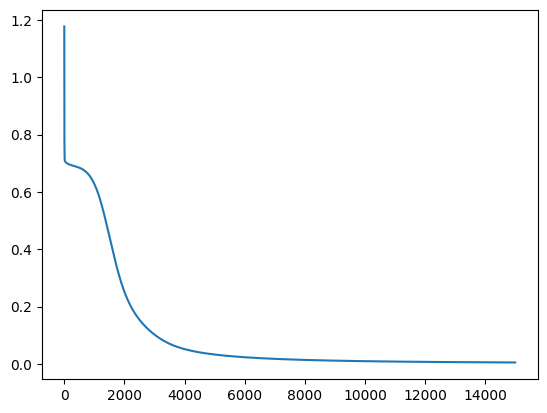

                    | Is negative | Is positive
--------------------+-------------+--------------
Negative prediction |         992 |           0
--------------------+-------------+--------------
Positive prediction |           0 |          32
########################################
Precision = 1.00000, Recall = 1.00000, F1 = 1.00000


In [18]:
plt.plot(loss)
plt.show()

conf_mat = evaluate_confusion(palindrome_network, word_length)
pretty_print_confusion(conf_mat)

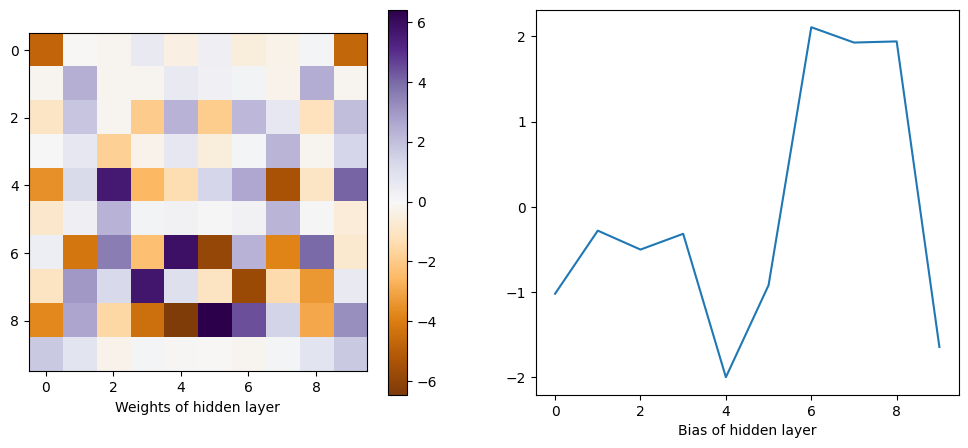

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

weight_pos = ax1.imshow(palindrome_network.hidden_layers[0].weights, cmap=plt.get_cmap('PuOr'))
plt.colorbar(weight_pos, ax=ax1)
ax1.set_xlabel('Weights of hidden layer')

ax2.plot(palindrome_network.hidden_layers[0].bias)
ax2.set_xlabel('Bias of hidden layer')

plt.show()

Bias of output layer :  [1.07765965]


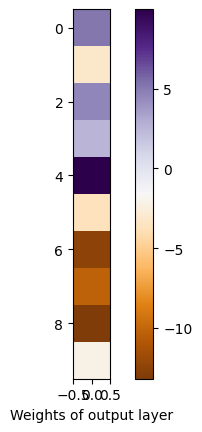

In [20]:
plt.imshow(palindrome_network.hidden_layers[1].weights.T, cmap=plt.get_cmap('PuOr'))
# plt.colorbar(orientation='horizontal')
plt.colorbar()
plt.xlabel('Weights of output layer')

print('Bias of output layer : ', palindrome_network.hidden_layers[1].bias)

plt.show()

In [21]:
#                                                                  ??????????
print(palindrome_network.calc_output( np.array(list(map(int, list('0000000000')))) ))
print(palindrome_network.calc_loss(1))

[0.99452487]
[0.00549017]


Code For k-fold validation

In [28]:
# word = np.array([1,0,1,0,1,1,0,1,0,1])
# n_epochs = 1

def measure_loss(model, test_data) :
  total_loss = 0
  total_importance = 0
  for test_case in test_data :
    word = test_case[0]
    is_palindrome = test_case[1]
    case_importance = 1
    if len(test_case) >= 3 :
      case_importance = test_case[2]
    # Test
    model.calc_output(word)
    total_loss += model.calc_loss( is_palindrome )
    total_importance += case_importance
  return total_loss/ len(test_data) #case_importance

def train_on_data(model, n_epochs, train_data, test_data, reg_constant, learning_rate) :
  loss_over_epochs = []
  for epoch_i in tqdm(range(n_epochs)) :
    for test_case in train_data :
      ## Randomly generate words
      # word = []
      # if np.random.rand() > 0.2 :
      #   word = word_generator(word_length)
      # else :
      #   word = palindrome_generator(word_length)
      ## Go through all words sequen tially
      word = test_case[0]
      is_palindrome = test_case[1]
      case_importance = test_case[2]
      # Train
      model.calc_output(word)
      model.calc_loss( is_palindrome )
      model.accumulate_delta(weight = case_importance)
    # Now update
    model.apply_update(learning_rate)
    model.regularize(reg_constant)
    loss_over_epochs.append(measure_loss(model, test_data))
  return loss_over_epochs

def k_fold_split(full_data, k, seed = 126702) :
  rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(seed)))
  np.random.shuffle(full_data)
  test_sets = []
  train_sets = []
  splits = []
  for i in range(k) :
    splits.append(full_data[int(np.floor((len(full_data) * i) / k)) : int(np.floor( (len(full_data) * (i+1)) / k))])
  for i in range(k) :
    train_set = []
    test_set = []
    for j in range(k) :
      if i == j :
        test_set += splits[j]
      else :
        train_set += splits[j]
    test_sets.append(test_set)
    train_sets.append(train_set)
  return [train_sets, test_sets]


In [29]:
all_words = [ np.array(list(map(int, list( format(i, '#0%sb' % (word_length + 2))[2:] )))) for i in range(2**(word_length)) ]
all_data = ( [ 
  [x, int(palindrome_determiner(x)), 1 if palindrome_determiner(x) else 2**(-word_length //2)]
    for x in all_words 
] )

Here we perform the 4-fold validation for 4k epochs.

In [30]:
four_fold_data = k_fold_split(all_data, 4, seed = 126702)

loss_f = SquareError()
activation_f = Sigmoid()

word_length = 10

n_epochs = 6000
learning_rate = 5e-3
reg_constant = 0
  

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [20:08<00:00,  4.97it/s]   


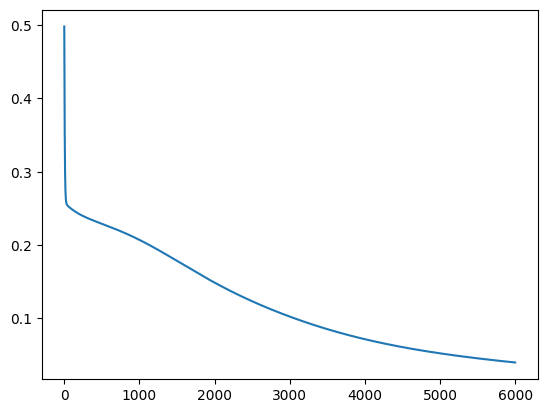

                    | Is negative | Is positive
--------------------+-------------+--------------
Negative prediction |         962 |           4
--------------------+-------------+--------------
Positive prediction |          30 |          28
########################################
Precision = 0.48276, Recall = 0.87500, F1 = 0.62222

 $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 



100%|██████████| 6000/6000 [27:14<00:00,  3.67it/s]     


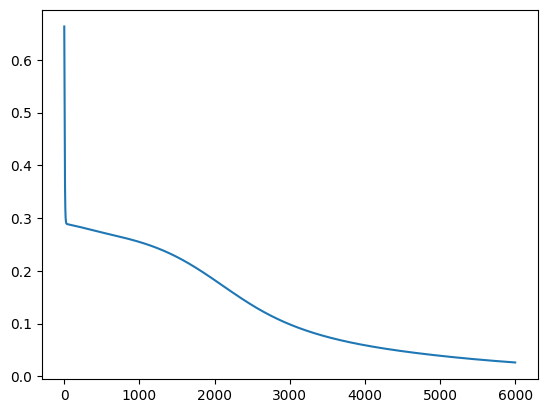

                    | Is negative | Is positive
--------------------+-------------+--------------
Negative prediction |         961 |           0
--------------------+-------------+--------------
Positive prediction |          31 |          32
########################################
Precision = 0.50794, Recall = 1.00000, F1 = 0.67368

 $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 



100%|██████████| 6000/6000 [12:14<00:00,  8.17it/s]


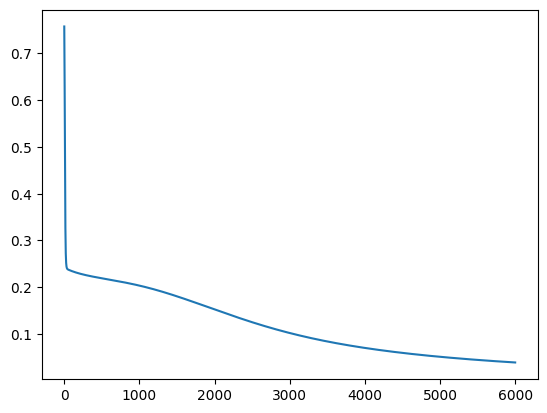

                    | Is negative | Is positive
--------------------+-------------+--------------
Negative prediction |         972 |           2
--------------------+-------------+--------------
Positive prediction |          20 |          30
########################################
Precision = 0.60000, Recall = 0.93750, F1 = 0.73171

 $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 



100%|██████████| 6000/6000 [10:51<00:00,  9.22it/s]


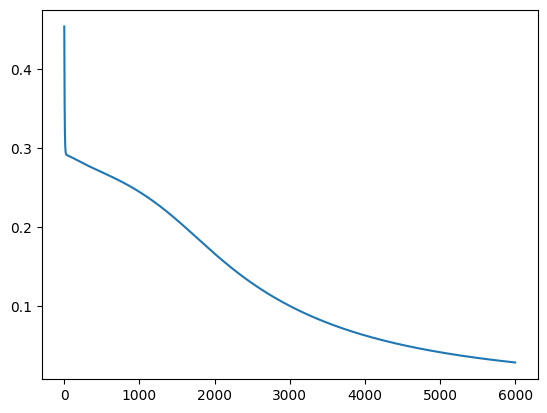

                    | Is negative | Is positive
--------------------+-------------+--------------
Negative prediction |         983 |           0
--------------------+-------------+--------------
Positive prediction |           9 |          32
########################################
Precision = 0.78049, Recall = 1.00000, F1 = 0.87671

 $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 



In [31]:
for i in range(4) :
  random_source = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(42)))
  model = Network(input_size=word_length, loss_layer=LossLayer(loss_f), 
                  hidden_layers=[Layer(20, activation_f),
                                  Layer(1, activation_f)],
                  random_state = random_source)
  loss = train_on_data(model, n_epochs, four_fold_data[0][i], four_fold_data[1][i], reg_constant, learning_rate)
  plt.plot(loss)
  plt.show()

  conf_mat = evaluate_confusion(model, word_length)
  pretty_print_confusion(conf_mat)
  print('\n', '$$'*20,'\n')

In the cell below, is the boolean formula of the palindrome formula, which is known to be 
$$
\operatorname{XNOR}(w[1], w[10]) \cdot \operatorname{XNOR}(w[2], w[9]) \cdot \operatorname{XNOR}(w[3], w[8]) \cdot \operatorname{XNOR}(w[4], w[7]) \cdot \operatorname{XNOR}(w[5], w[6])
$$
expressed as a network. We first form the XNOR in it's sum-of-products form in the first two layers, then AND them together in the output layer.

In [535]:
palindrome_network = Network(input_size=word_length, loss_layer=LossLayer(loss_f), 
                             hidden_layers= [Layer(10, activation_f), 
                                             Layer(5, activation_f),
                                             Layer(1, activation_f)]
                            )
palindrome_network.hidden_layers[0].weights = 10.0 * np.array([
  [1, 0, 0, 0, 0,  0, 0, 0, 0, 1],
  [0, 1, 0, 0, 0,  0, 0, 0, 1, 0],
  [0, 0, 1, 0, 0,  0, 0, 1, 0, 0],
  [0, 0, 0, 1, 0,  0, 1, 0, 0, 0],
  [0, 0, 0, 0, 1,  1, 0, 0, 0, 0],
  [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
  [0, -1, 0, 0, 0, 0, 0, 0, -1, 0],
  [0, 0, -1, 0, 0, 0, 0, -1, 0, 0],
  [0, 0, 0, -1, 0, 0, -1, 0, 0, 0],
  [0, 0, 0, 0, -1, -1, 0, 0, 0, 0],
])
palindrome_network.hidden_layers[0].bias = 5.0 * np.array([3,3,3,3,3, -1, -1, -1, -1, -1 ])

palindrome_network.hidden_layers[1].weights = 10.0 * np.array([
  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
])
palindrome_network.hidden_layers[1].bias = 5.0 * np.ones(5)

palindrome_network.hidden_layers[2].weights = 10.0 * np.ones((1,5))
palindrome_network.hidden_layers[2].bias = np.array([40.0])

However, we can write XNOR in it's product-of-sums form instead, and then the product of products can be coallesced into a single layer, limiting the network to just 2 layers.

We can thus also observe that via the sum-of-products or the product-of-sums of Boolean formulae, any Boolean formula can be expressed as a 2-layered FFN. The only cost is that the number of neurons in the hidden layer scale as $\mathcal{O}(2^n)$, where $n$ is the number of inputs.

In [573]:
palindrome_network = Network(word_length, LossLayer(loss_f), 
                             [Layer(10, activation_f),
                              Layer(1, activation_f)]
                            )
palindrome_network.hidden_layers[0].weights = 10.0 * np.array([
  [1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
  [0, 1, 0, 0, 0, 0, 0, 0, -1, 0],
  [0, 0, 1, 0, 0, 0, 0, -1, 0, 0],
  [0, 0, 0, 1, 0, 0, -1, 0, 0, 0],
  [0, 0, 0, 0, 1, -1, 0, 0, 0, 0],
  [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [0, -1, 0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, -1, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, -1, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 0, -1, 1, 0, 0, 0, 0],
])
palindrome_network.hidden_layers[0].bias = -5.0 * np.ones(10)

palindrome_network.hidden_layers[1].weights = 10.0 * np.ones((1,10))
palindrome_network.hidden_layers[1].bias = 95.0 * np.ones(1)

In [183]:
np.array(list(map(int, list('011001010101'))))

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1])